In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Module
import math
import rdflib
import torch.nn as nn
import torch.optim as optim
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, GPT2ForSequenceClassification
from transformers import BertModel, RobertaModel, GPT2Model
from transformers import BertTokenizer, RobertaTokenizer, GPT2Tokenizer
from torch.utils.data import DataLoader, Dataset, random_split
import networkx as nx
import random
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from torch.nn import DataParallel
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import openai
from openai import OpenAI
#from sklearn.decomposition import PCA
from chromadb import Client
from chromadb.config import Settings
from chromadb.db.mixins.sysdb import UniqueConstraintError
import os


In [2]:
class BERTClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, label_input_ids=None, label_attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        
        if label_input_ids is not None and label_attention_mask is not None:
            label_outputs = self.bert(input_ids=label_input_ids, attention_mask=label_attention_mask)
            label_pooled_output = label_outputs[1]
            label_pooled_output = self.dropout(label_pooled_output)
            pooled_output = pooled_output + label_pooled_output
        
        logits = self.classifier(pooled_output)
        return pooled_output, logits


In [3]:
class RoBERTaClassifier(nn.Module):
    def __init__(self, num_labels):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, label_input_ids=None, label_attention_mask=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)

        if label_input_ids is not None and label_attention_mask is not None:
            label_outputs = self.roberta(input_ids=label_input_ids, attention_mask=label_attention_mask)
            label_pooled_output = label_outputs[1]
            label_pooled_output = self.dropout(label_pooled_output)
            pooled_output = pooled_output + label_pooled_output

        logits = self.classifier(pooled_output)
        return pooled_output, logits


In [4]:

class GPT2Classifier(nn.Module):
    def __init__(self, num_labels):
        super(GPT2Classifier, self).__init__()
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.gpt2.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, label_input_ids=None, label_attention_mask=None):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, -1, :]
        pooled_output = self.dropout(pooled_output)

        if label_input_ids is not None and label_attention_mask is not None:
            label_outputs = self.gpt2(input_ids=label_input_ids, attention_mask=label_attention_mask)
            label_pooled_output = label_outputs[0][:, -1, :]
            label_pooled_output = self.dropout(label_pooled_output)
            pooled_output = pooled_output + label_pooled_output

        logits = self.classifier(pooled_output)
        return pooled_output, logits
    
    def resize_token_embeddings(self, new_num_tokens):
        self.gpt2.resize_token_embeddings(new_num_tokens)

In [5]:
#SEEDING
import random
random.seed(42)  # Set the seed to a fixed number


In [6]:
torch.manual_seed(42)  # Set the seed for PyTorch


In [7]:
print(torch.__version__)  #1.11.0+cpu
print(torch.cuda.is_available())


2.5.1+cu124
True


In [8]:
if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} GPUs available")
else:
    print("Single GPU or no GPU available")


6 GPUs available


In [9]:

# If using CUDA (PyTorch)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.


In [10]:
# Enforce deterministic behavior in PyTorch (optional, may impact performance)
# This is important for reproducibility, especially for certain operations on GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
os.getcwd()

'/home/rapids/notebooks/slima'

In [12]:
# Constants
ontology_path = "/home/rapids/notebooks/slima/doid.owl"

#Consider reducing the scaling factor s or the angular margin m to see if it helps 
#stabilize training.
sglobal = 32.0
scale_s = sglobal
mglobal = 0.25
margin = mglobal
tau_values = [0.1, 0.5, 0.9]
easy_marginglobal = False
embedding_dim = 768
output_dim = 512
#Consider tuning the learning rate further, as the current one might be too high for these specialized loss functions.
learning_rate = 0.001
momentum = 0.1
weight_decay = 5e-4
num_epochs = 100
query = "What is acinar histologic pattern?"
disease="cancer"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
number_nearest_vectors=5
model_p = {}
precision=4

# Initialize dictionaries to hold tokenizers and datasets for each model
tokenizers = {}
datasets = {}
# Initialize a dictionary to hold DataLoader objects for each model
dataloaders = {}
embedding_to_text = {}

# Define base directory where models are stored
base_dir = '/home/rapids/notebooks/slima'

# Generate model paths dynamically for all combinations
model_paths = {}



In [13]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:

g = rdflib.Graph()
g.parse(ontology_path)


<Graph identifier=N2288d6174ea7416c9d9ec76cbfd4b025 (<class 'rdflib.graph.Graph'>)>

In [15]:
all_uris = set()
for s, p, o in g:
    if isinstance(s, rdflib.term.URIRef):
        all_uris.add(str(s))
    if isinstance(o, rdflib.term.URIRef):
        all_uris.add(str(o))

# Create a mapping from all unique URIs to numerical labels
all_uris = list(all_uris)
disease_type_mapping = {uri: idx for idx, uri in enumerate(all_uris)}


In [16]:

num_classes = len(disease_type_mapping)  # Adjust based on your data
print(num_classes)

15488


In [17]:

# Focal Loss Function
class FocalLoss(Module):
    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()


In [18]:

# ArcMargin Product for ArcFace
class ArcMarginProduct(Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = torch.cos(torch.tensor(m))  # Convert m to a tensor
        self.sin_m = torch.sin(torch.tensor(m))  # Convert m to a tensor
        self.th = torch.cos(torch.tensor(math.pi) - torch.tensor(m))  # Convert math.pi and m to tensors
        self.mm = torch.sin(torch.tensor(math.pi) - torch.tensor(m)) * m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=label.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output


In [19]:

# Fuzzy ArcFace
class FuzzyArcFace(Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.50, tau=0.9, easy_margin=False):
        super(FuzzyArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.tau = tau
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = easy_margin

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        fuzzy_membership = cosine
        mask = torch.logical_and(torch.logical_and(fuzzy_membership > 0, fuzzy_membership >= self.tau), fuzzy_membership <= 1)
        fuzzy_membership = torch.where(mask, fuzzy_membership, torch.ones_like(fuzzy_membership))
        m_adjusted = self.m * fuzzy_membership
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        cos_m_adjusted = torch.cos(m_adjusted)
        sin_m_adjusted = torch.sin(m_adjusted)
        phi = cosine * cos_m_adjusted - sine * sin_m_adjusted
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > torch.cos(torch.tensor(math.pi) - m_adjusted), phi, cosine - torch.sin(torch.tensor(math.pi) - m_adjusted) * m_adjusted)
        one_hot = torch.zeros(cosine.size(), device=label.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output


In [20]:
class CustomTextDataset(Dataset):
    def __init__(self, labels_and_urls, tokenizer):
        self.labels_and_urls = labels_and_urls
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels_and_urls)

    def __getitem__(self, idx):
        label, url = self.labels_and_urls[idx]
        encoded_input = self.tokenizer(url, padding='max_length', truncation=True, return_tensors='pt')
        input_ids = encoded_input['input_ids'].squeeze(0)
        attention_mask = encoded_input['attention_mask'].squeeze(0)
        
        # Tokenize the label text
        encoded_label = self.tokenizer(label, padding='max_length', truncation=True, return_tensors='pt')
        label_input_ids = encoded_label['input_ids'].squeeze(0)
        label_attention_mask = encoded_label['attention_mask'].squeeze(0)

        return input_ids, attention_mask, label_input_ids, label_attention_mask, label, url  # Return tokenized text label and URL
    
    def get_shapes(self):
        input_ids, attention_mask, label_input_ids, label_attention_mask, _, _ = self[0]
        return {
            'num_samples': len(self),
            'input_ids_shape': input_ids.shape,
            'attention_mask_shape': attention_mask.shape,
            'label_input_ids_shape': label_input_ids.shape,
            'label_attention_mask_shape': label_attention_mask.shape,
        }

In [21]:
def extract_textual_info(rdf_graph):
    texts = {}
    for subj, pred, obj in rdf_graph:
        if pred in [rdflib.RDFS.label, rdflib.namespace.DCTERMS.description]:
            if subj not in texts:
                texts[subj] = []
            texts[subj].append(str(obj))
    return texts

In [22]:

texts = extract_textual_info(g)

In [23]:
# Print the first 10 registers of texts
count = 0
for subj, labels in texts.items():
    print(f"Subject: {subj}")
    for label in labels:
        print(f" - {label}")
    count += 1
    if count >= 30:
        break

Subject: http://purl.obolibrary.org/obo/DOID_0110127
 - Bardet-Biedl syndrome 5
Subject: http://purl.obolibrary.org/obo/DOID_7505
 - small intestine benign neoplasm
Subject: http://purl.obolibrary.org/obo/DOID_0060397
 - chromosome 15q26-qter deletion syndrome
Subject: http://purl.obolibrary.org/obo/DOID_2421
 - obsolete skin fibrous tissue neoplasm
Subject: http://purl.obolibrary.org/obo/DOID_12402
 - pyromania
Subject: http://purl.obolibrary.org/obo/DOID_9413
 - obsolete Congenital abnormalities of uterus complicating pregnancy, childbirth, or the puerperium
Subject: http://purl.obolibrary.org/obo/DOID_4682
 - extrahepatic bile duct carcinoma
Subject: http://purl.obolibrary.org/obo/DOID_5958
 - bladder urachal carcinoma
Subject: http://purl.obolibrary.org/obo/DOID_11725
 - Cornelia de Lange syndrome
Subject: http://purl.obolibrary.org/obo/DOID_5022
 - aflatoxins-related hepatocellular carcinoma
Subject: http://purl.obolibrary.org/obo/DOID_0080611
 - anterior segment dysgenesis 6
Subj

In [24]:

def filter_lung_cancer_texts(texts):
    lung_cancer_texts = []
    for text_list in texts.values():
        for text in text_list:
            if disease in text.lower():
                lung_cancer_texts.append(text)
                break  # No need to check further once "lung cancer" is found
    return lung_cancer_texts

In [25]:

# Convert RDF graph to NetworkX graph
nx_graph = nx.DiGraph()
for subj, pred, obj in g:
    nx_graph.add_edge(subj, obj, predicate=pred)


In [26]:
def resolve_blank_nodes(graph):
    resolved_graph = nx.DiGraph()
    blank_node_mappings = {}

    # Collect parents and children of blank nodes
    for subj, obj, data in graph.edges(data=True):
        pred = data.get('predicate', None)
        if isinstance(subj, rdflib.BNode) or isinstance(obj, rdflib.BNode):
            if isinstance(subj, rdflib.BNode):
                if subj not in blank_node_mappings:
                    blank_node_mappings[subj] = {'parents': set(), 'children': set()}
                blank_node_mappings[subj]['children'].add((obj, pred))
            if isinstance(obj, rdflib.BNode):
                if obj not in blank_node_mappings:
                    blank_node_mappings[obj] = {'parents': set(), 'children': set()}
                blank_node_mappings[obj]['parents'].add((subj, pred))
        else:
            if pred:
                resolved_graph.add_edge(subj, obj, predicate=pred)

    # Connect parents and children of blank nodes
    for blank_node, mappings in blank_node_mappings.items():
        for parent, parent_pred in mappings['parents']:
            for child, child_pred in mappings['children']:
                resolved_graph.add_edge(parent, child, predicate=parent_pred)

    return resolved_graph

# Apply the function
resolved_nx_graph = resolve_blank_nodes(nx_graph)


In [27]:

def extract_lung_cancer_subgraph(graph, lung_cancer_nodes):
    subgraph = nx.Graph()
    for node in lung_cancer_nodes:
        for neighbor in graph.neighbors(node):
            if neighbor in lung_cancer_nodes:
                subgraph.add_edge(node, neighbor)
    return subgraph

In [28]:
def find_lung_cancer_nodes(graph, rdf_graph, dis):
    lung_cancer_nodes = set()
    labels_dict = {}
    for node in graph.nodes():
        for url, _, label in rdf_graph.triples((node, rdflib.RDFS.label, None)):
            labels_dict[node] = str(label)
            if dis in str(label).lower():
                lung_cancer_nodes.add(node)
    return lung_cancer_nodes, labels_dict


In [29]:
# Find nodes related to "lung cancer"
lung_cancer_nodes, labels_dict = find_lung_cancer_nodes(resolved_nx_graph, g, disease)


In [30]:
# Extract the subgraph
lung_cancer_subgraph = extract_lung_cancer_subgraph(resolved_nx_graph, lung_cancer_nodes)


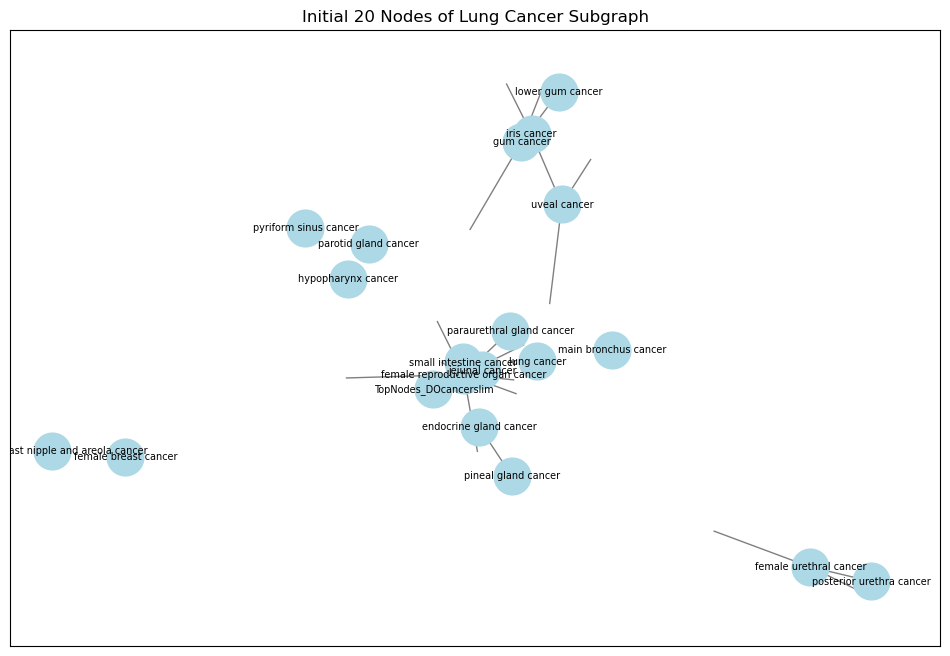

In [31]:
# Plot the initial 10 nodes of the subgraph
pos = nx.spring_layout(lung_cancer_subgraph)
plt.figure(figsize=(12, 8))
number_nodes=20
# Draw the nodes and edges
nx.draw_networkx_nodes(lung_cancer_subgraph, pos, node_size=700, nodelist=list(lung_cancer_subgraph.nodes())[:number_nodes], node_color='lightblue')
nx.draw_networkx_edges(lung_cancer_subgraph, pos, edgelist=list(lung_cancer_subgraph.edges())[:number_nodes], alpha=0.5)
#nx.draw_networkx_labels(lung_cancer_subgraph, pos, labels={node: node for node in list(lung_cancer_subgraph.nodes())[:number_nodes]}, font_size=7)
# Use labels from the labels_dict
nx.draw_networkx_labels(lung_cancer_subgraph, pos, labels={node: labels_dict[node] for node in list(lung_cancer_subgraph.nodes())[:number_nodes]}, font_size=7)

plt.title("Initial 20 Nodes of Lung Cancer Subgraph")
plt.show()


In [32]:
# Create combined data with labels and URLs only
combined_data = [(labels_dict[node], str(node)) for node in lung_cancer_subgraph.nodes() if node in labels_dict]



In [33]:
# Preprocess combined data
def preprocess_combined_data(combined_data):
    preprocessed_data = ["{}: {}".format(label, url) for label, url in combined_data]
    print("Combined Data Structure:", combined_data)

    return preprocessed_data

In [34]:
# Preprocess the combined data
preprocessed_data = preprocess_combined_data(combined_data)


Combined Data Structure: [('iris cancer', 'http://purl.obolibrary.org/obo/DOID_3478'), ('uveal cancer', 'http://purl.obolibrary.org/obo/DOID_3479'), ('lower gum cancer', 'http://purl.obolibrary.org/obo/DOID_9125'), ('gum cancer', 'http://purl.obolibrary.org/obo/DOID_8602'), ('paraurethral gland cancer', 'http://purl.obolibrary.org/obo/DOID_14059'), ('female reproductive organ cancer', 'http://purl.obolibrary.org/obo/DOID_120'), ('posterior urethra cancer', 'http://purl.obolibrary.org/obo/DOID_7488'), ('female urethral cancer', 'http://purl.obolibrary.org/obo/DOID_738'), ('pineal gland cancer', 'http://purl.obolibrary.org/obo/DOID_5032'), ('endocrine gland cancer', 'http://purl.obolibrary.org/obo/DOID_170'), ('female breast nipple and areola cancer', 'http://purl.obolibrary.org/obo/DOID_11889'), ('female breast cancer', 'http://purl.obolibrary.org/obo/DOID_0050671'), ('jejunal cancer', 'http://purl.obolibrary.org/obo/DOID_13499'), ('small intestine cancer', 'http://purl.obolibrary.org/o

In [35]:
# Display preprocessed data
for data in preprocessed_data:
    print(data)

iris cancer: http://purl.obolibrary.org/obo/DOID_3478
uveal cancer: http://purl.obolibrary.org/obo/DOID_3479
lower gum cancer: http://purl.obolibrary.org/obo/DOID_9125
gum cancer: http://purl.obolibrary.org/obo/DOID_8602
paraurethral gland cancer: http://purl.obolibrary.org/obo/DOID_14059
female reproductive organ cancer: http://purl.obolibrary.org/obo/DOID_120
posterior urethra cancer: http://purl.obolibrary.org/obo/DOID_7488
female urethral cancer: http://purl.obolibrary.org/obo/DOID_738
pineal gland cancer: http://purl.obolibrary.org/obo/DOID_5032
endocrine gland cancer: http://purl.obolibrary.org/obo/DOID_170
female breast nipple and areola cancer: http://purl.obolibrary.org/obo/DOID_11889
female breast cancer: http://purl.obolibrary.org/obo/DOID_0050671
jejunal cancer: http://purl.obolibrary.org/obo/DOID_13499
small intestine cancer: http://purl.obolibrary.org/obo/DOID_10154
TopNodes_DOcancerslim: http://purl.obolibrary.org/obo/doid#TopNodes_DOcancerslim
main bronchus cancer: http

In [36]:
# Filter out entries with default labels (-1)
filtered_data = [(label, url) for label, url in combined_data if label != -1]
filtered_labels, filtered_urls = zip(*filtered_data)

In [37]:
# Check the unique labels and their counts
unique_labels = set(filtered_labels)
print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

Unique labels: {'pancreatic cancer', 'uterine cancer', 'iris cancer', 'long bones of lower limb cancer', 'infratentorial cancer', 'cardiovascular cancer', 'testicular malignant germ cell cancer', 'endocardium cancer', 'oropharynx cancer', 'female breast central part cancer', 'breast cancer', 'vestibule of mouth cancer', 'thoracic cancer', 'hepatobiliary system cancer', 'heart cancer', 'lacrimal system cancer', 'sternum cancer', 'adrenal medulla cancer', 'extragonadal germ cell cancer', 'ileum cancer', 'estrogen-receptor positive breast cancer', 'bile duct cancer', 'cerebrum cancer', 'bone marrow cancer', 'female breast cancer', 'vulva cancer', 'anal canal cancer', 'muscle cancer', 'urinary bladder posterior wall cancer', 'glans penis cancer', 'stomach cancer', 'lung hilum cancer', 'pyloric antrum cancer', 'esophageal cancer', 'uterine ligament cancer', 'testis refractory cancer', 'testicular cancer', 'bladder neck cancer', 'kidney cancer', 'adrenal gland cancer', 'brain cancer', "Walde

In [38]:
# Define models and loss functions
models = {
    'BERT': BERTClassifier,
    'RoBERTa': RoBERTaClassifier,
    'GPT2': GPT2Classifier
}

loss_fns = {
    'plain': nn.CrossEntropyLoss().to(device),
    'arcface': ArcMarginProduct(in_features=embedding_dim, out_features=len(unique_labels),  s=scale_s, m=margin, easy_margin=easy_marginglobal).to(device),
    'fuzzyarcface': [FuzzyArcFace(in_features=embedding_dim, out_features=len(unique_labels),  s=scale_s, m=margin, tau=tau, easy_margin=easy_marginglobal).to(device) for tau in tau_values]

}

In [39]:
# Count the number of entries in preprocessed_data
num_preprocessed_entries = len(preprocessed_data)
print(f"Number of entries in preprocessed_data: {num_preprocessed_entries}")


Number of entries in preprocessed_data: 268


In [40]:

# Count the number of entries in labels
num_labels_entries = len(filtered_labels)
#num_labels_entries = len(preprocessed_data[1])

print(f"Number of entries in labels: {num_labels_entries}")



Number of entries in labels: 268


In [41]:
# Label to ID mapping
label_to_id = {label: idx for idx, label in enumerate(set(filtered_labels))}
id_to_label = {idx: label for label, idx in label_to_id.items()}


In [42]:
# Iterate over each model name and its corresponding class
for model_name in models.keys():
    if model_name == 'BERT':
        tokenizers[model_name] = BertTokenizer.from_pretrained('bert-base-uncased')
    elif model_name == 'RoBERTa':
        tokenizers[model_name] = RobertaTokenizer.from_pretrained('roberta-base')
    elif model_name == 'GPT2':  # Uncomment if using GPT2
        tokenizers[model_name] = GPT2Tokenizer.from_pretrained('gpt2')
        # Set padding token
        tokenizers[model_name].pad_token = tokenizers[model_name].eos_token  # Use EOS token as padding
    
    # Create the dataset and store it in the datasets dictionary
    datasets[model_name] = CustomTextDataset(labels_and_urls=combined_data, tokenizer=tokenizers[model_name])


In [43]:
# Create combined data with labels and URLs
combined_data = [(label, url) for label, url in zip(filtered_labels, filtered_urls)]


In [44]:

#ontology_data=filtered_data
ontology_data=lung_cancer_subgraph

In [45]:
# Iterate through each dataset and print its shapes
for model_name, dataset in datasets.items():
    if model_name != 'GPT2':
        print(f"Dataset shapes for model: {model_name}")
        dataset_shapes = dataset.get_shapes()
        print(f"  Number of samples: {dataset_shapes['num_samples']}")
        print(f"  Input IDs shape: {dataset_shapes['input_ids_shape']}")
        print(f"  Attention mask shape: {dataset_shapes['attention_mask_shape']}")
        print(f"  Label Input IDs shape: {dataset_shapes['label_input_ids_shape']}")
        print(f"  Label Attention mask shape: {dataset_shapes['label_attention_mask_shape']}")
        print("\n")  # Add a newline for readability between different models
    else:
        print(f"Dataset shapes for model: {model_name}")
        dataset.tokenizer.pad_token = dataset.tokenizer.eos_token  
        dataset_shapes = dataset.get_shapes()
        
        print(f"  Number of samples: {dataset_shapes['num_samples']}")
        print(f"  Input IDs shape: {dataset_shapes['input_ids_shape']}")
        print(f"  Attention mask shape: {dataset_shapes['attention_mask_shape']}")
        print("\n")  # Add a newline for readability between different models


Dataset shapes for model: BERT
  Number of samples: 268
  Input IDs shape: torch.Size([512])
  Attention mask shape: torch.Size([512])
  Label Input IDs shape: torch.Size([512])
  Label Attention mask shape: torch.Size([512])


Dataset shapes for model: RoBERTa
  Number of samples: 268
  Input IDs shape: torch.Size([512])
  Attention mask shape: torch.Size([512])
  Label Input IDs shape: torch.Size([512])
  Label Attention mask shape: torch.Size([512])


Dataset shapes for model: GPT2
  Number of samples: 268
  Input IDs shape: torch.Size([1024])
  Attention mask shape: torch.Size([1024])




In [46]:

# Iterate over each model name and its corresponding class
for model_name, model_class in models.items():
    print(f"Processing model: {model_name}")
    
    # Retrieve the dataset for the current model
    dataset = datasets[model_name]
    
    # Create a DataLoader for the dataset and store it in the dataloaders dictionary
    dataloaders[model_name] = DataLoader(dataset, batch_size=32, shuffle=True)


Processing model: BERT
Processing model: RoBERTa
Processing model: GPT2


In [47]:

def normalize_embeddings(embeddings):
    return F.normalize(embeddings, p=2, dim=1)


In [48]:
def train_and_save_model(model, dataloader, optimizer, loss_fn, device, model_path, label_to_id, epochs=num_epochs):
    """
    Trains the model and saves it to a specified path.

    Args:
    - model: The model to be trained.
    - dataloader: The DataLoader for the model.
    - optimizer: Optimizer for training.
    - loss_fn: Loss function to use.
    - device: The device (CPU/GPU) to use for training.
    - model_path: Path to save the model after training.
    - label_to_id: Dictionary mapping text labels to IDs.
    - epochs: Number of training epochs (default is 5).
    """
    
    model.train()  # Set the model to training mode
    
    for epoch in range(epochs):
        total_loss = 0  # Track the total loss for this epoch
        
        for batch in dataloader:
            optimizer.zero_grad()  # Zero out the gradients before each step
            
            # Unpack the batch and move tensors to the appropriate device
            b_input_ids, b_input_mask, b_label_input_ids, b_label_attention_mask, b_text_labels, _ = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_label_input_ids = b_label_input_ids.to(device)
            b_label_attention_mask = b_label_attention_mask.to(device)
            
            # Convert text labels to tensor indices using label_to_id and move to device
            b_text_labels = torch.tensor([label_to_id[label] for label in b_text_labels], dtype=torch.long)
            b_text_labels = b_text_labels.to(device)

            # Forward pass: calculate logits and pooled_output from the model
            pooled_output, logits = model(
                input_ids=b_input_ids, 
                attention_mask=b_input_mask, 
                label_input_ids=b_label_input_ids, 
                label_attention_mask=b_label_attention_mask
            )
            
            # Ensure logits and labels are in the correct shape for loss calculation
            logits = logits.view(-1, logits.size(-1))  # Reshape logits for classification
            b_text_labels = b_text_labels.view(-1)  # Reshape labels to match logits
            
            # Handle different loss functions
            if isinstance(loss_fn, (ArcMarginProduct, FuzzyArcFace)):
                # If using ArcFace or FuzzyArcFace, normalize embeddings if needed
                loss = loss_fn(pooled_output, b_text_labels)  # ArcFace-style loss
                loss = nn.CrossEntropyLoss()(loss, b_text_labels)  # Apply CrossEntropyLoss
            else:
                # For standard loss functions like CrossEntropy
                loss = loss_fn(logits, b_text_labels)  # Apply the given loss function
            
            # Backward pass: compute gradients
            loss.backward()
            
            # Optimization step: update the model parameters
            optimizer.step()
            
            total_loss += loss.item()  # Accumulate loss for this epoch
            
        # Calculate and print the average loss for this epoch
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')
    
    # Save the model to the specified path
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


In [49]:
# Example function to check models and loss functions
def print_model_and_loss_info(models, loss_fns):
    for model_name, model in models.items():
        print(f"Model: {model_name}")
        print(model)
    for loss_name, loss_fn in loss_fns.items():
        if isinstance(loss_fn, list):
            for i, lf in enumerate(loss_fn):
                print(f"Loss Function: {loss_name} (tau={tau_values[i]})")
                print(lf)
        else:
            print(f"Loss Function: {loss_name}")
            print(loss_fn)

# Print the models and loss functions to verify
print_model_and_loss_info(models, loss_fns)

Model: BERT
<class '__main__.BERTClassifier'>
Model: RoBERTa
<class '__main__.RoBERTaClassifier'>
Model: GPT2
<class '__main__.GPT2Classifier'>
Loss Function: plain
CrossEntropyLoss()
Loss Function: arcface
ArcMarginProduct()
Loss Function: fuzzyarcface (tau=0.1)
FuzzyArcFace()
Loss Function: fuzzyarcface (tau=0.5)
FuzzyArcFace()
Loss Function: fuzzyarcface (tau=0.9)
FuzzyArcFace()


TRAINING

In [50]:
# Iterate over each model and corresponding class
for model_name, model_class in models.items():
    print(f"Model: {model_name}")
    
    # Access the correct DataLoader for the current model
    dataloader = dataloaders[model_name]
    
    for loss_name, loss_fn in loss_fns.items():
        if loss_name == 'fuzzyarcface':
            print(loss_name)
            for tau, fuzzy_loss_fn in zip(tau_values, loss_fn):
                print("fuzzyarcface tau value...", tau)
                
                # Re-initialize the model
                model = model_class(num_labels_entries).to(device)
                model = DataParallel(model)
                
                # Set up the optimizer
                optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
                
                # Construct the model path
                model_path = f'{model_name}_fuzzyarcface_tau{tau}.pth'
                model_paths[f'{model_name}_fuzzyarcface_tau{tau}'] = model_path
                print("model paths...i...", model_paths[f'{model_name}_fuzzyarcface_tau{tau}'])
                
                # Train and save the model
                train_and_save_model(model, dataloader, optimizer, fuzzy_loss_fn.to(device), device, model_path, label_to_id)
                
        else:
            print(loss_name)
            
            # Re-initialize the model
            model = model_class(num_labels_entries).to(device)
            model = DataParallel(model)
            
            # Set up the optimizer
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
            
            # Construct the model path
            model_path = f'{model_name}_{loss_name}.pth'
            model_paths[f'{model_name}_{loss_name}'] = model_path
            
            # Train and save the model
            train_and_save_model(model, dataloader, optimizer, loss_fn.to(device), device, model_path, label_to_id)


Model: BERT
plain
Epoch 1/100, Loss: 5.8851537174648705
Epoch 2/100, Loss: 5.747037463717991
Epoch 3/100, Loss: 5.744579209221734
Epoch 4/100, Loss: 5.748028543260363
Epoch 5/100, Loss: 5.738498051961263
Epoch 6/100, Loss: 5.749211311340332
Epoch 7/100, Loss: 5.714708911048041
Epoch 8/100, Loss: 5.6582261721293134
Epoch 9/100, Loss: 5.692223760816786
Epoch 10/100, Loss: 5.672528425852458
Epoch 11/100, Loss: 5.696133613586426
Epoch 12/100, Loss: 5.645351886749268
Epoch 13/100, Loss: 5.651921272277832
Epoch 14/100, Loss: 5.6523320939805775
Epoch 15/100, Loss: 5.644122017754449
Epoch 16/100, Loss: 5.660446219974094
Epoch 17/100, Loss: 5.627696673075358
Epoch 18/100, Loss: 5.655706564585368
Epoch 19/100, Loss: 5.664479202694363
Epoch 20/100, Loss: 5.6397276984320746
Epoch 21/100, Loss: 5.626241313086616
Epoch 22/100, Loss: 5.628303474850124
Epoch 23/100, Loss: 5.62078857421875
Epoch 24/100, Loss: 5.6177670160929365
Epoch 25/100, Loss: 5.615153047773573
Epoch 26/100, Loss: 5.611168066660563

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100, Loss: 5.671120484670003
Epoch 2/100, Loss: 5.6392891142103405
Epoch 3/100, Loss: 5.628469096289741
Epoch 4/100, Loss: 5.628797213236491
Epoch 5/100, Loss: 5.6238705846998425
Epoch 6/100, Loss: 5.640511194864909
Epoch 7/100, Loss: 5.617839760250515
Epoch 8/100, Loss: 5.632935629950629
Epoch 9/100, Loss: 5.6167282528347435
Epoch 10/100, Loss: 5.624542448255751
Epoch 11/100, Loss: 5.619206057654487
Epoch 12/100, Loss: 5.633345444997151
Epoch 13/100, Loss: 5.625450558132595
Epoch 14/100, Loss: 5.624035411410862
Epoch 15/100, Loss: 5.620275391472711
Epoch 16/100, Loss: 5.626029756334093
Epoch 17/100, Loss: 5.617484940422906
Epoch 18/100, Loss: 5.621221118503147
Epoch 19/100, Loss: 5.601326041751438
Epoch 20/100, Loss: 5.602101484934489
Epoch 21/100, Loss: 5.605224185519749
Epoch 22/100, Loss: 5.621784528096517
Epoch 23/100, Loss: 5.609219021267361
Epoch 24/100, Loss: 5.6239938206142845
Epoch 25/100, Loss: 5.621381706661648
Epoch 26/100, Loss: 5.622474564446343
Epoch 27/100, Los

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100, Loss: 14.169290330674913
Epoch 2/100, Loss: 14.090168105231392
Epoch 3/100, Loss: 13.921848085191515
Epoch 4/100, Loss: 13.91553126441108
Epoch 5/100, Loss: 13.844500223795572
Epoch 6/100, Loss: 13.867147551642525
Epoch 7/100, Loss: 13.821606424119738
Epoch 8/100, Loss: 13.835535049438477
Epoch 9/100, Loss: 13.740061653984917
Epoch 10/100, Loss: 13.762512101067436
Epoch 11/100, Loss: 13.736941125657824
Epoch 12/100, Loss: 13.717769198947483
Epoch 13/100, Loss: 13.730622397528755
Epoch 14/100, Loss: 13.736507097880045
Epoch 15/100, Loss: 13.768043412102593
Epoch 16/100, Loss: 13.754742410447863
Epoch 17/100, Loss: 13.659040239122179
Epoch 18/100, Loss: 13.741168551974827
Epoch 19/100, Loss: 13.746930652194553
Epoch 20/100, Loss: 13.766577508714464
Epoch 21/100, Loss: 13.713459226820204
Epoch 22/100, Loss: 13.686065779791939
Epoch 23/100, Loss: 13.693512068854439
Epoch 24/100, Loss: 13.754081726074219
Epoch 25/100, Loss: 13.736186345418295
Epoch 26/100, Loss: 13.691696590847

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model paths...i... RoBERTa_fuzzyarcface_tau0.1.pth
Epoch 1/100, Loss: 14.108560138278538
Epoch 2/100, Loss: 13.972100575764975
Epoch 3/100, Loss: 13.961707644992405
Epoch 4/100, Loss: 13.881659083896214
Epoch 5/100, Loss: 13.882022751702202
Epoch 6/100, Loss: 13.859102037217882
Epoch 7/100, Loss: 13.802719010247124
Epoch 8/100, Loss: 13.814686563279894
Epoch 9/100, Loss: 13.823949284023708
Epoch 10/100, Loss: 13.784526295132107
Epoch 11/100, Loss: 13.76127200656467
Epoch 12/100, Loss: 13.696017689175076
Epoch 13/100, Loss: 13.784838146633572
Epoch 14/100, Loss: 13.782916598849827
Epoch 15/100, Loss: 13.765601052178276
Epoch 16/100, Loss: 13.70795398288303
Epoch 17/100, Loss: 13.756732092963325
Epoch 18/100, Loss: 13.72269164191352
Epoch 19/100, Loss: 13.737031830681694
Epoch 20/100, Loss: 13.69144238366021
Epoch 21/100, Loss: 13.70734977722168
Epoch 22/100, Loss: 13.694677140977648
Epoch 23/100, Loss: 13.721064037746853
Epoch 24/100, Loss: 13.70439444647895
Epoch 25/100, Loss: 13.66717

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model paths...i... RoBERTa_fuzzyarcface_tau0.5.pth
Epoch 1/100, Loss: 14.113384352789986
Epoch 2/100, Loss: 14.041102197435167
Epoch 3/100, Loss: 13.89665306939019
Epoch 4/100, Loss: 13.870211919148764
Epoch 5/100, Loss: 13.83987988366021
Epoch 6/100, Loss: 13.850191434224447
Epoch 7/100, Loss: 13.774257765875923
Epoch 8/100, Loss: 13.774576505025228
Epoch 9/100, Loss: 13.79071479373508
Epoch 10/100, Loss: 13.726838217841255
Epoch 11/100, Loss: 13.776977115207249
Epoch 12/100, Loss: 13.772268825107151
Epoch 13/100, Loss: 13.803662300109863
Epoch 14/100, Loss: 13.774795108371311
Epoch 15/100, Loss: 13.724754863315159
Epoch 16/100, Loss: 13.726385010613335
Epoch 17/100, Loss: 13.748497009277344
Epoch 18/100, Loss: 13.699175834655762
Epoch 19/100, Loss: 13.753340509202745
Epoch 20/100, Loss: 13.674446847703722
Epoch 21/100, Loss: 13.712403827243381
Epoch 22/100, Loss: 13.675487942165798
Epoch 23/100, Loss: 13.747414906819662
Epoch 24/100, Loss: 13.693787574768066
Epoch 25/100, Loss: 13.69

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model paths...i... RoBERTa_fuzzyarcface_tau0.9.pth
Epoch 1/100, Loss: 14.09008820851644
Epoch 2/100, Loss: 14.060453626844618
Epoch 3/100, Loss: 13.953837606641981
Epoch 4/100, Loss: 13.869446224636501
Epoch 5/100, Loss: 13.870602289835611
Epoch 6/100, Loss: 13.88396962483724
Epoch 7/100, Loss: 13.767698287963867
Epoch 8/100, Loss: 13.72844738430447
Epoch 9/100, Loss: 13.797979884677464
Epoch 10/100, Loss: 13.75267251332601
Epoch 11/100, Loss: 13.74516815609402
Epoch 12/100, Loss: 13.732077386644152
Epoch 13/100, Loss: 13.709376017252604
Epoch 14/100, Loss: 13.751637670728895
Epoch 15/100, Loss: 13.733159277174208
Epoch 16/100, Loss: 13.723747889200846
Epoch 17/100, Loss: 13.76411141289605
Epoch 18/100, Loss: 13.769239531622993
Epoch 19/100, Loss: 13.728468788994682
Epoch 20/100, Loss: 13.785096380445692
Epoch 21/100, Loss: 13.74551953209771
Epoch 22/100, Loss: 13.598201751708984
Epoch 23/100, Loss: 13.713781462775337
Epoch 24/100, Loss: 13.692349645826551
Epoch 25/100, Loss: 13.705914

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Epoch 1/100, Loss: 7.987042003207737
Epoch 2/100, Loss: 6.021042240990533
Epoch 3/100, Loss: 5.86858950720893
Epoch 4/100, Loss: 5.8065295749240455
Epoch 5/100, Loss: 5.801574760013157
Epoch 6/100, Loss: 5.7712267769707575
Epoch 7/100, Loss: 5.784429497188992
Epoch 8/100, Loss: 5.720553398132324
Epoch 9/100, Loss: 5.687497456868489
Epoch 10/100, Loss: 5.707649336920844
Epoch 11/100, Loss: 5.711244583129883
Epoch 12/100, Loss: 5.6999526553683815
Epoch 13/100, Loss: 5.677990330590142
Epoch 14/100, Loss: 5.660165150960286
Epoch 15/100, Loss: 5.682212299770779
Epoch 16/100, Loss: 5.663378556569417
Epoch 17/100, Loss: 5.6634960704379615
Epoch 18/100, Loss: 5.660321023729113
Epoch 19/100, Loss: 5.65933010313246
Epoch 20/100, Loss: 5.634287516276042
Epoch 21/100, Loss: 5.642777972751194
Epoch 22/100, Loss: 5.663870440589057
Epoch 23/100, Loss: 5.674029085371229
Epoch 24/100, Loss: 5.646141423119439
Epoch 25/100, Loss: 5.639116340213352
Epoch 26/100, Loss: 5.679657671186659
Epoch 27/100, Loss:

TESTING

In [51]:

import re
# Pattern to match valid Python function names
pattern = r'\b([A-Za-z_][A-Za-z0-9_]*)\b'

# Extract function names from the keys of the dictionary
function_names = [key for key in loss_fns.keys()]

# Print the unique function names
unique_function_names = set(function_names)
print(unique_function_names)

{'plain', 'fuzzyarcface', 'arcface'}


In [52]:
import openai

client = OpenAI(
    api_key=openai.api_key
)

def send_to_openai(combined_input):
    try:
        stream = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful oncological assistant that answers oncological questions and uses links/urls as sources for your response."},
                {"role": "user", "content": combined_input}
            ],
            stream=True,
        )
        
        response_text = ""

        for chunk in stream:
            # Access and print the content field
            content = chunk.choices[0].delta.content
            if content:  # Only print if there's content
                #print("Content:", content)
                response_text += content
        
        print("Generated response:", response_text)
        return response_text if response_text else None

    except openai.error.OpenAIError as e:
        print(f"OpenAI API returned an error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


In [53]:
chroma_client = Client(Settings())


In [54]:
# Assume `chroma_client` is your Chroma client instance

# List all collections in Chroma
collections = chroma_client.list_collections()

# Iterate over all collections and delete them
for collection_name in collections:
    try:
        chroma_client.delete_collection(collection_name)
        print(f"Deleted collection: {collection_name}")
    except Exception as e:
        print(f"Failed to delete collection {collection_name}: {e}")


In [55]:
import uuid

def add_ontology_vectors_to_chroma(collection_name, ontology_embeddings, ontology_embedding_to_text, precision=5):
    try:
        collection = chroma_client.create_collection(collection_name)
    except UniqueConstraintError:
        collection = chroma_client.get_collection(collection_name)

    embeddings_list = []
    metadatas_list = []
    ids_list = []
    
    for idx, embedding in enumerate(ontology_embeddings):
        key = round_embedding(embedding, decimals=precision)  # Create the same key by rounding the embedding
        if key in ontology_embedding_to_text:
            embeddings_list.append(embedding)
            metadatas_list.append({"text": ontology_embedding_to_text[key]})
            ids_list.append(str(uuid.uuid4()))  # Generate a unique ID for each embedding
        else:
            print(f"Key not found for index {idx}: {key}")
            
    # Assuming ontology_embeddings is a list of numpy arrays
    embeddings_list = [embedding.tolist() for embedding in ontology_embeddings]

    
    # Add the embeddings, metadata, and ids to the collection
    collection.add(
        embeddings=embeddings_list,  # The embeddings to add
        metadatas=metadatas_list,    # The associated metadata for each embedding
        ids=ids_list                 # Unique identifiers for each embedding
    )
    
    return collection


In [56]:
def find_closest_vectors_chroma(query_vector, collection_name, top_k=number_nearest_vectors):
    collection = chroma_client.get_collection(collection_name)
    results = collection.query(query_vector, n_results=top_k)
    print("Results structure:", results)
    
    # Extract closest texts from the 'metadatas' key in results, removing "No URL"
    closest_texts = [meta['text'].split(": ")[0] for meta in results['metadatas'][0]]
    
    return closest_texts



In [57]:
def preprocess_combined_data(graph):
    preprocessed_data = []
    
    # Iterate over the nodes and their attributes
    for node, data in graph.nodes(data=True):
        # Extract specific attributes (e.g., 'label' and 'url')
        label = data.get('label', node)  # Fallback to the node itself if 'label' is missing
        url = data.get('url', 'No URL')  # Default to 'No URL' if 'url' is missing
        
        preprocessed_data.append(f"{label}: {url}")
    
    return preprocessed_data

In [58]:
def get_ontology_embeddings(data, model):
    #embedding_to_text = {}
    global ontology_embedding_to_text
    ontology_embedding_to_text = {}
    
    
    preprocessed_data = preprocess_combined_data(data)
    encoded_data = tokenizer(preprocessed_data, padding=True, truncation=True, return_tensors='pt')
    input_ids = encoded_data['input_ids'].to(device)
    attention_mask = encoded_data['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    
    # Handle the case where outputs is a tuple
    if isinstance(outputs, tuple):
        embeddings = outputs[0]
    else:
        embeddings = outputs

     # Ensure embeddings are properly reduced in dimension
    if embeddings.dim() > 2:
        embeddings = embeddings.mean(dim=1)  # Example, adjust as needed
        
            # Convert embeddings to CPU and numpy, then round to the desired precision
    embeddings = embeddings.cpu().numpy()
    embeddings = np.round(embeddings, decimals=precision)
        
           # Map embeddings to their corresponding text
    for idx, text in enumerate(preprocessed_data):
        ontology_embedding_to_text[tuple(embeddings[idx])] = text  # Using the tuple of the embedding as a key


    print(f"Embeddings shape after mean in get_ontology: {embeddings.shape}")
    return embeddings

In [59]:
def load_state_dict_with_handling(model, state_dict):
    new_state_dict = {}
    if list(state_dict.keys())[0].startswith('module.'):
        for k, v in state_dict.items():
            new_state_dict[k.replace('module.', '')] = v
        state_dict = new_state_dict

    if 'GPT2' in model.__class__.__name__:
        keys_to_remove = ['gpt2.wte.weight']
        for key in keys_to_remove:
            if key in state_dict:
                del state_dict[key]

    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    return model


In [60]:
def load_model_and_tokenizer(models, loss_fns, tau_values, model_paths, tokenizers):
    loaded_models = {}

    for model_name, model_class in models.items():
        # Retrieve the correct tokenizer from the tokenizers dictionary
        tokenizer = tokenizers[model_name]

        for loss_name, loss_fn in loss_fns.items():
            if loss_name == 'fuzzyarcface':
                for tau, fuzzy_loss_fn in zip(tau_values, loss_fn):
                    state_dict_path = model_paths[f'{model_name}_{loss_name}_tau{tau}']
                    print(f"Loading model for {model_name} with {loss_name} (tau={tau}) from {state_dict_path}")
                    model = model_class(num_labels_entries)
                    state_dict = torch.load(state_dict_path)
                    model = load_state_dict_with_handling(model, state_dict)
                    # Store the model, tokenizer, and fuzzy loss function
                    loaded_models[f"{model_name}_{loss_name}_tau{tau}"] = (model, tokenizer, fuzzy_loss_fn)
            else:
                state_dict_path = model_paths[f'{model_name}_{loss_name}']
                print(f"Loading model for {model_name} with {loss_name} from {state_dict_path}")
                model = model_class(num_labels_entries)
                state_dict = torch.load(state_dict_path)
                model = load_state_dict_with_handling(model, state_dict)
                # Store the model, tokenizer, and standard loss function
                loaded_models[f"{model_name}_{loss_name}"] = (model, tokenizer, loss_fn)

    return loaded_models


In [61]:

for model_name in models.keys():
    for loss_name, loss_fn in loss_fns.items():
        if loss_name == 'fuzzyarcface':
            for tau in tau_values:
                model_key = f'{model_name}_{loss_name}_tau{tau}'
                model_paths[model_key] = f'{base_dir}/{model_name}_{loss_name}_tau{tau}.pth'
        else:
            model_key = f'{model_name}_{loss_name}'
            model_paths[model_key] = f'{base_dir}/{model_name}_{loss_name}.pth'

# Example print of model paths to verify correctness
for key, path in model_paths.items():
    print(f"{key}: {path}")


BERT_plain: /home/rapids/notebooks/slima/BERT_plain.pth
BERT_arcface: /home/rapids/notebooks/slima/BERT_arcface.pth
BERT_fuzzyarcface_tau0.1: /home/rapids/notebooks/slima/BERT_fuzzyarcface_tau0.1.pth
BERT_fuzzyarcface_tau0.5: /home/rapids/notebooks/slima/BERT_fuzzyarcface_tau0.5.pth
BERT_fuzzyarcface_tau0.9: /home/rapids/notebooks/slima/BERT_fuzzyarcface_tau0.9.pth
RoBERTa_plain: /home/rapids/notebooks/slima/RoBERTa_plain.pth
RoBERTa_arcface: /home/rapids/notebooks/slima/RoBERTa_arcface.pth
RoBERTa_fuzzyarcface_tau0.1: /home/rapids/notebooks/slima/RoBERTa_fuzzyarcface_tau0.1.pth
RoBERTa_fuzzyarcface_tau0.5: /home/rapids/notebooks/slima/RoBERTa_fuzzyarcface_tau0.5.pth
RoBERTa_fuzzyarcface_tau0.9: /home/rapids/notebooks/slima/RoBERTa_fuzzyarcface_tau0.9.pth
GPT2_plain: /home/rapids/notebooks/slima/GPT2_plain.pth
GPT2_arcface: /home/rapids/notebooks/slima/GPT2_arcface.pth
GPT2_fuzzyarcface_tau0.1: /home/rapids/notebooks/slima/GPT2_fuzzyarcface_tau0.1.pth
GPT2_fuzzyarcface_tau0.5: /home/ra

In [62]:
def round_embedding(embedding, decimals=5):
    """
    Rounds the elements of an embedding to the specified number of decimal places.
    
    Parameters:
    - embedding: A numpy array representing the embedding.
    - decimals: Number of decimal places to round to.
    
    Returns:
    - A tuple with the rounded embedding values.
    """
    return tuple(np.round(embedding, decimals))


In [63]:
loaded_models = load_model_and_tokenizer(models, loss_fns, tau_values, model_paths, tokenizers)


Loading model for BERT with plain from /home/rapids/notebooks/slima/BERT_plain.pth


/tmp/ipykernel_2352934/3608061472.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)


Loading model for BERT with arcface from /home/rapids/notebooks/slima/BERT_arcface.pth
Loading model for BERT with fuzzyarcface (tau=0.1) from /home/rapids/notebooks/slima/BERT_fuzzyarcface_tau0.1.pth


/tmp/ipykernel_2352934/3608061472.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)


Loading model for BERT with fuzzyarcface (tau=0.5) from /home/rapids/notebooks/slima/BERT_fuzzyarcface_tau0.5.pth
Loading model for BERT with fuzzyarcface (tau=0.9) from /home/rapids/notebooks/slima/BERT_fuzzyarcface_tau0.9.pth
Loading model for RoBERTa with plain from /home/rapids/notebooks/slima/RoBERTa_plain.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model for RoBERTa with arcface from /home/rapids/notebooks/slima/RoBERTa_arcface.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model for RoBERTa with fuzzyarcface (tau=0.1) from /home/rapids/notebooks/slima/RoBERTa_fuzzyarcface_tau0.1.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model for RoBERTa with fuzzyarcface (tau=0.5) from /home/rapids/notebooks/slima/RoBERTa_fuzzyarcface_tau0.5.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model for RoBERTa with fuzzyarcface (tau=0.9) from /home/rapids/notebooks/slima/RoBERTa_fuzzyarcface_tau0.9.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model for GPT2 with plain from /home/rapids/notebooks/slima/GPT2_plain.pth
Loading model for GPT2 with arcface from /home/rapids/notebooks/slima/GPT2_arcface.pth
Loading model for GPT2 with fuzzyarcface (tau=0.1) from /home/rapids/notebooks/slima/GPT2_fuzzyarcface_tau0.1.pth
Loading model for GPT2 with fuzzyarcface (tau=0.5) from /home/rapids/notebooks/slima/GPT2_fuzzyarcface_tau0.5.pth
Loading model for GPT2 with fuzzyarcface (tau=0.9) from /home/rapids/notebooks/slima/GPT2_fuzzyarcface_tau0.9.pth


In [64]:
def generate_vectors(model, tokenizer, texts, device, embedding_dim):
    model.eval()  # Set the model to evaluation mode
    print("Input texts:", texts)

    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=embedding_dim)
    print("Tokenized inputs:", inputs)

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Initialize a dictionary to map embeddings to text
    embedding_to_text = {}

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        #print("Model outputs:", outputs)

        # Check if the model output is a single tensor or a tuple containing logits
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Assuming the first element is the logits tensor

        print("Outputs after checking tuple:", outputs.shape)

        # No mean calculation if outputs should be used directly
        embeddings = outputs
        print(f"Shape of embeddings: {embeddings.shape}")

        for text_item, embedding in zip(texts, embeddings):
            if isinstance(embedding, torch.Tensor):
                embedding = embedding.cpu().numpy()
                if embedding.ndim == 0:  # If embedding is a scalar
                    embedding = [embedding]
                embedding_to_text[tuple(map(float, embedding))] = text_item  # Convert each element to float before creating tuple

    return embeddings.cpu().numpy(), embedding_to_text


In [65]:
# Now iterate over the loaded models
for combination_name, (model, tokenizer, loss_fn) in loaded_models.items():
    print(f"Processing combination: {combination_name}")

    # Generate ontology embeddings for each combination
    ontology_embeddings = get_ontology_embeddings(ontology_data, model)
    collection_name = f"ontology_embeddings_{combination_name}"
    print("collection name...", collection_name)
    collection = add_ontology_vectors_to_chroma(collection_name, ontology_embeddings, ontology_embedding_to_text)

    # Generate query vectors
    query_vectors, query_embedding_to_text = generate_vectors(model, tokenizer, query, device, embedding_dim)

    # Find closest texts
    closest_texts = find_closest_vectors_chroma(query_vectors, collection_name, top_k=number_nearest_vectors)

    # Generate combined input
    combined_input = f"Query: {query}\\n Access these links and complement your answer and conclude if the links are related or not to the query. Give a score where 1 is lowest relationship and 10 is highest relationship. At the end give an OVERALL score that should be the average of all scores: {' '.join(closest_texts)}"
    print(combined_input)

    # Send to OpenAI
    response = send_to_openai(combined_input)
    #print(f"Response for {combination_name}: {response}")

Processing combination: BERT_plain
Embeddings shape after mean in get_ontology: (268, 768)
collection name... ontology_embeddings_BERT_plain
Input texts: What is acinar histologic pattern?
Tokenized inputs: {'input_ids': tensor([[  101,  2054,  2003,  9353,  3981,  2099,  2010,  3406, 27179,  5418,
          1029,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Outputs after checking tuple: torch.Size([1, 768])
Shape of embeddings: torch.Size([1, 768])
Results structure: {'ids': [['e11e977b-a7de-4c2d-948b-5a1c7ec08645', '3c7405a2-a62e-4eb1-9acb-f12b4fbb1d59', '453b82d9-cae2-41c1-8c82-3cd376facb3e', 'd71d9831-8395-4f06-918c-52a4f45c3cf4', '659bb186-083b-4e03-8c0c-4631780759d1']], 'embeddings': None, 'documents': [[None, None, None, None, None]], 'uris': None, 'data': None, 'metadatas': [[{'text': 'http://purl.obolibrary.org/obo/DOID_1785: No URL'}, {'text': 'http://purl.obolibrary.org/obo/DOID_